In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']

In [3]:
price_dataframe = yf.download(tickers, period='max')['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


In [4]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

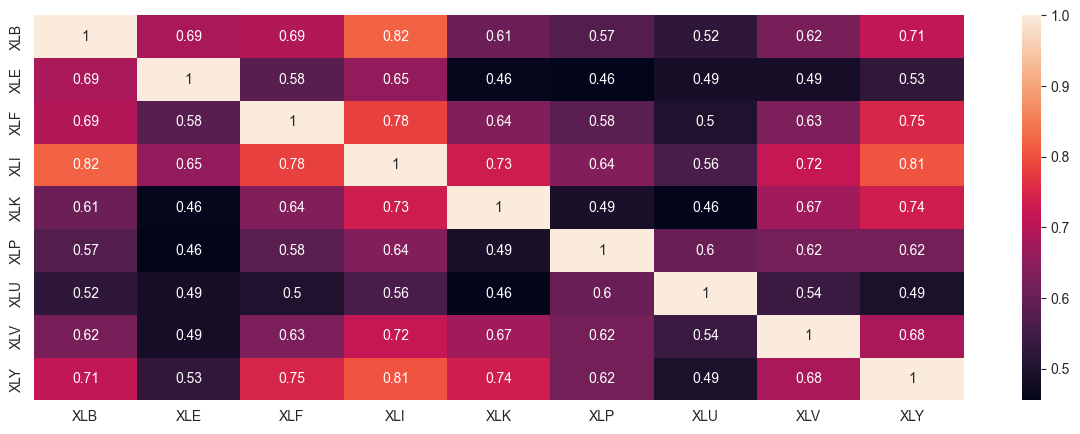

In [9]:
lookbacks = np.arange(2, 252+1, 1)

sns.heatmap(normalizedDataframe.corr(), annot=True)
plt.show()

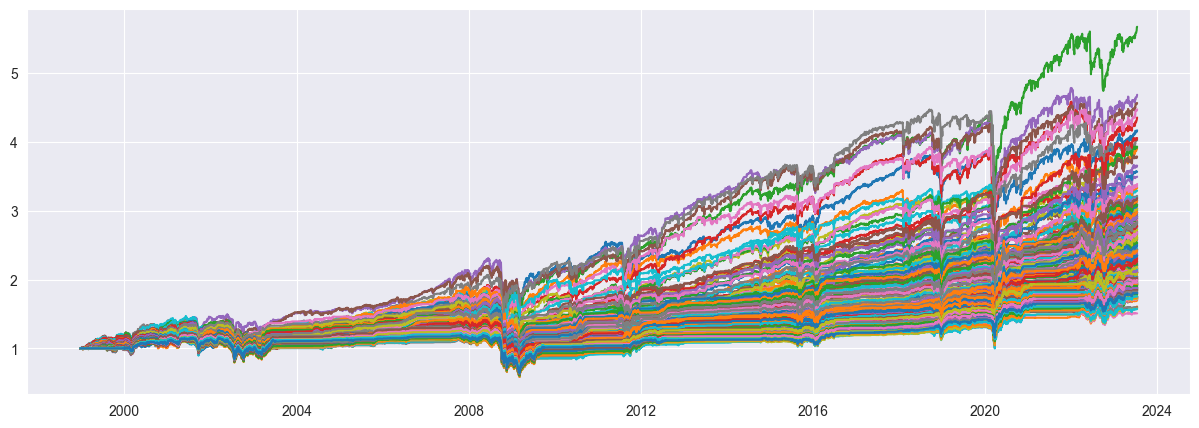

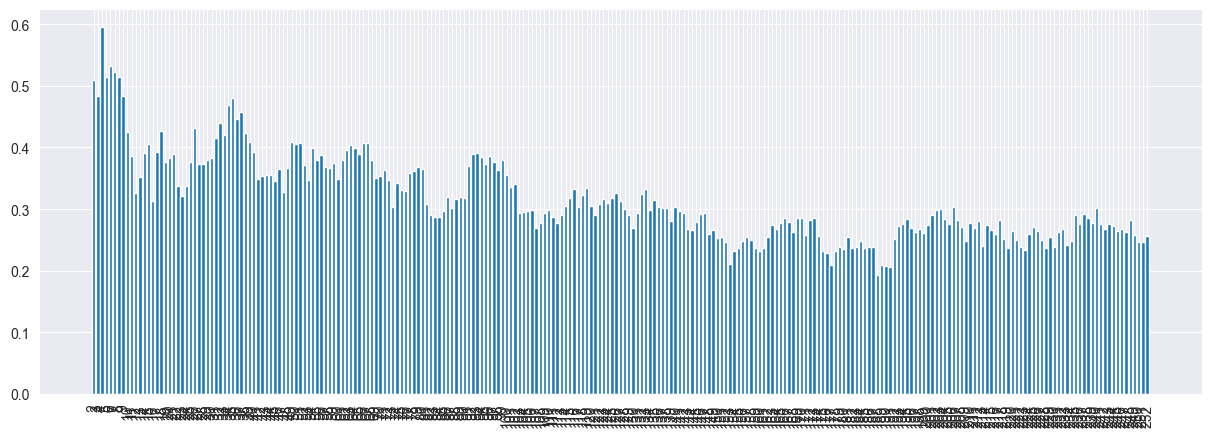

In [26]:
def backtest(dataframe, lookbacks, sharpes):
    for lookback in lookbacks:
        signal = None

        weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

        signal = dataframe.rolling(lookback).sum() < 0

        weighted_signal = signal.mul(weights)

        portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)

        cumulative_returns = (portfolio_returns + 1).cumprod()
        plt.plot(cumulative_returns)

        # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
        sharpes.append((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    # plt.legend(lookbacks)
    plt.show()

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

backtest(normalizedDataframe, lookbacks, [])

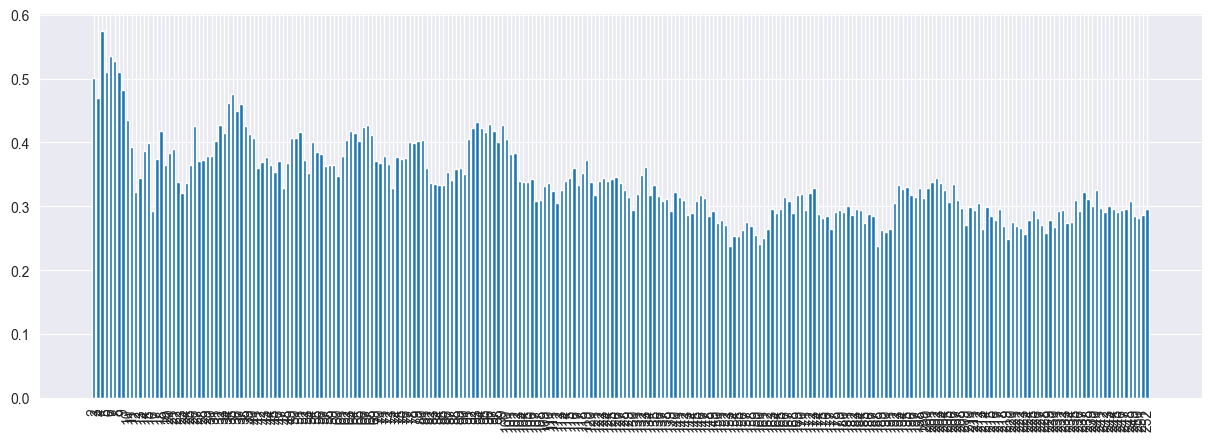

In [27]:
# divide dataframe into 2 and combine the average scores of both sharpes and mdds and plot that
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/3)]
    second = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    third = dataframe.iloc[int(len(dataframe)/3)*2:]

    dataframes = [first, second, third]

    sharpes = np.zeros((len(lookbacks), 3))

    for i, dataframe in enumerate(dataframes):
        # print('Fold', i+1)
        for j, lookback in enumerate(lookbacks):

            weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

            signal = dataframe.rolling(lookback).sum() < 0

            weighted_signal = signal.mul(weights)

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            # print(lookback)
            # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

4
Sharpe 0.5948150993839677


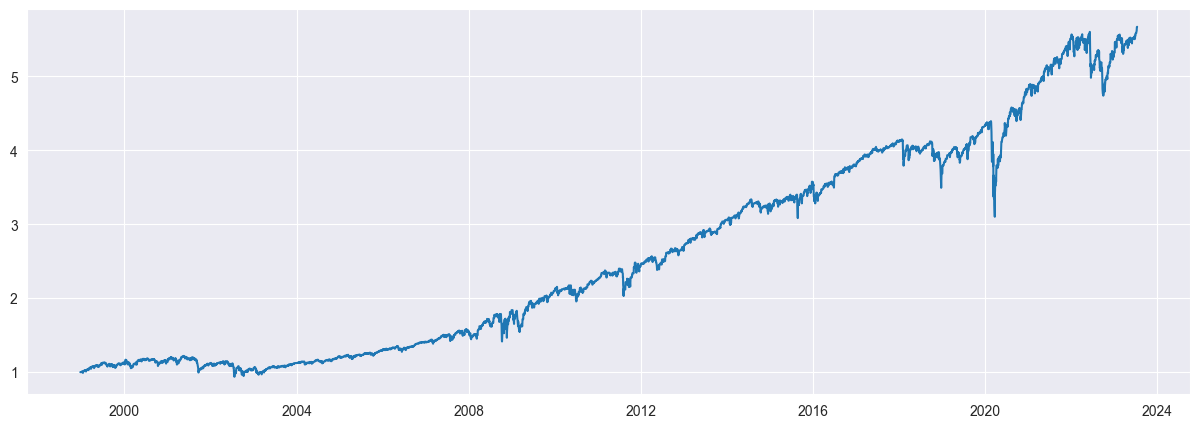

Assets contributing most to strategy (highest to lowest): 
XLK    0.284956
XLE    0.279288
XLF    0.269134
XLV    0.250059
XLB    0.192546
XLP    0.188303
XLU    0.179620
XLY    0.179428
XLI    0.132560
dtype: float64


In [28]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print(lookback)

    weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

    signal = dataframe.rolling(lookback).sum() < 0

    weighted_signal = signal.mul(weights)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    plt.show()

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Assets contributing most to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The best lookback parameter for this time series short term reversal strategy is 4 days and the highest returning sector is the tech sector. Its interesting how this strategy completely skips the 2008 GFC, which is likely just a fluke, as it didn't do the same for the 2020 covid crash.